#  Анализ датасета US Stores Sales

**Описание датасета**

Датасет содержит информацию о стоимости продаж в долларах в американских магазинах в период с 2010 по 2011 год.

[Ссылка](https://www.kaggle.com/datasets/dsfelix/us-stores-sales)




_Обозначения_

**`Area Code:`** Store's Code

**`State:`** Store's State

**`Market:`** Store's Region

**`Market Size:`** Store's Size

**`Profit:`** Profits in Dollars ($)

**`Margin:`** Profit + Total Expenses ($) OR Sales - COGS ($)

**`Sales:`** Values Acquired in Sales ($)

**`COGS:`** Cost of Goods Sold ($)

**`Total Expenses:`** Total Expenses to get the Product to Sell ($)

**`Marketing:`** Expenses in Marketing ($)

**`Inventory:`** Inventory Value of the Product in the Sale Moment ($)

**`Budget Profit:`** Expected Profit ($)

**`Budget COGS`**: Expected COGS ($)

**`Budget Margin:`** Expected Profit + Expected Total Expenses ($) OR Expected Sales - Expected COGS ($)

**`Budget Sales:`** Expected Value Acquired in Sales ($)

**`ProductID:`** Product ID

**`Date:`** Sale Date

**`Product Type:`** Product Category

**`Product:`** Product Description

**`Type:`** Type


**Цель работы:** проанализировать датасет и выявить инсайты о рынке Америки

In [1]:
!pip -qqq install catboost plotly

In [2]:
# импортируем нужные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score
from scipy.stats import ttest_ind, chi2_contingency, shapiro

In [3]:
# импортируем файл
df = pd.read_csv('sales.csv')

In [4]:
# смотрим файл
df.head()

Area Code        State Market   Market Size  Profit  Margin  Sales   COGS  \
0        203  Connecticut   East  Small Market   107.0   176.0  292.0  116.0   
1        203  Connecticut   East  Small Market    75.0   135.0  225.0   90.0   
2        203  Connecticut   East  Small Market   122.0   195.0  325.0  130.0   
3        203  Connecticut   East  Small Market   105.0   174.0  289.0  115.0   
4        203  Connecticut   East  Small Market   104.0   135.0  223.0   90.0   

   Total Expenses  Marketing  Inventory  Budget Profit  Budget COGS  \
0            69.0       38.0      962.0          110.0        110.0   
1            60.0       29.0     1148.0           90.0         80.0   
2            73.0       42.0     1134.0          130.0        110.0   
3            69.0       37.0     1166.0          110.0        100.0   
4            56.0       29.0     1148.0           90.0         80.0   

   Budget Margin  Budget Sales  ProductId               Date Product Type  \
0          160.0         270.0          2  04/01/10 00:00:00       Coffee   
1          130.0         210.0          2  07/01/10 00:00:00       Coffee   
2          180.0         290.0          2  11/01/10 00:00:00       Coffee   
3          160.0         260.0          2  12/01/10 00:00:00       Coffee   
4          130.0         210.0          2  07/01/11 00:00:00       Coffee   

     Product     Type  
0  Columbian  Regular  
1  Columbian  Regular  
2  Columbian  Regular  
3  Columbian  Regular  
4  Columbian  Regular

**Работа с пропущенными значениями и дублями**

In [5]:
# найдем пропущенные значения
df.isna().sum()

Area Code         0
State             0
Market            0
Market Size       0
Profit            0
Margin            0
Sales             0
COGS              0
Total Expenses    0
Marketing         0
Inventory         0
Budget Profit     0
Budget COGS       0
Budget Margin     0
Budget Sales      0
ProductId         0
Date              0
Product Type      0
Product           0
Type              0
dtype: int64

Датасет не содержит пропущенных значений

In [6]:
# проверим наличие дублей
df.duplicated().value_counts()

False    4248
dtype: int64

Датасет не содержит дублей

**Типы переменных**

In [7]:
# посмотрим на тип переменных в датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4248 entries, 0 to 4247
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Area Code       4248 non-null   int64  
 1   State           4248 non-null   object 
 2   Market          4248 non-null   object 
 3   Market Size     4248 non-null   object 
 4   Profit          4248 non-null   float64
 5   Margin          4248 non-null   float64
 6   Sales           4248 non-null   float64
 7   COGS            4248 non-null   float64
 8   Total Expenses  4248 non-null   float64
 9   Marketing       4248 non-null   float64
 10  Inventory       4248 non-null   float64
 11  Budget Profit   4248 non-null   float64
 12  Budget COGS     4248 non-null   float64
 13  Budget Margin   4248 non-null   float64
 14  Budget Sales    4248 non-null   float64
 15  ProductId       4248 non-null   int64  
 16  Date            4248 non-null   object 
 17  Product Type    4248 non-null   o

В датасете содержится 11 целочисленных переменных, 2 переменные с плавающей точкой и 7 строковых переменных

**EDA, описательные статистики и визуализация данных**

Сделаем общее описание данных

In [8]:
df.describe().transpose()

count        mean         std     min     25%    50%    75%  \
Area Code       4248.0  582.278013  221.140310   203.0  417.00  573.0  772.0   
Profit          4248.0   61.097693  101.708546  -638.0   17.00   40.0   92.0   
Margin          4248.0  104.293315   94.342522  -302.0   52.75   76.0  132.0   
Sales           4248.0  192.987524  151.133127    17.0  100.00  138.0  230.0   
COGS            4248.0   84.433145   67.249769     0.0   43.00   60.0  100.0   
Total Expenses  4248.0   54.063559   32.352598    10.0   33.00   46.0   65.0   
Marketing       4248.0   31.185028   27.023264     0.0   13.00   22.0   39.0   
Inventory       4248.0  749.381356  661.031896 -3534.0  432.00  619.0  910.5   
Budget Profit   4248.0   60.913371   79.546123  -320.0   20.00   40.0   80.0   
Budget COGS     4248.0   74.830508   66.238145     0.0   30.00   50.0   90.0   
Budget Margin   4248.0  100.819209   92.602725  -210.0   50.00   70.0  130.0   
Budget Sales    4248.0  175.649718  148.891522     0.0   80.00  130.0  210.0   
ProductId       4248.0    6.887006    3.664072     1.0    4.00    6.0   10.0   

                   max  
Area Code        985.0  
Profit           778.0  
Margin           613.0  
Sales            912.0  
COGS             364.0  
Total Expenses   190.0  
Marketing        156.0  
Inventory       8252.0  
Budget Profit    560.0  
Budget COGS      450.0  
Budget Margin    690.0  
Budget Sales    1140.0  
ProductId         13.0

In [9]:
# создадим новую переменную is_profitable – 1, если прибыль положительная, 0, иначе
df['is_profitable'] = df['Profit'] > 0

In [10]:
# посчитаем сколько в датасете положительной и отрицательной прибыли
df['is_profitable'].value_counts()

True     3688
False     560
Name: is_profitable, dtype: int64

3688 положительная и 560 отрицательная или 0

Найдем, какой тип продукта занимает большую долю продаж

In [11]:
fig=px.pie(df.groupby('Product Type',as_index=False)['Sales'].count().sort_values(by='Sales',ascending=False).head(10),
           names='Product Type',values='Sales',color='Product Type',
           labels={'Product Type':'Product Type','Sales':'Sales Count'},template='ggplot2',
           title='<b>Доля продаж по типу продукта')
fig.update_layout(title_x=0.5,legend=dict(orientation='h',yanchor='bottom',
                                          y=1.02,xanchor='right',x=1))

Наибольшую долю продаж занимает кофе. Посмотрим как распределяются продажи кофе по маркам

Посмотрим на данные в табличном виде

In [12]:
most_sell = df.groupby('Product',as_index=False)['Sales'].sum().sort_values(by='Sales',ascending=False)
most_sell

Product     Sales
4           Columbian  128311.0
10              Lemon   95926.0
2         Caffe Mocha   84904.0
6      Decaf Espresso   78162.0
3           Chamomile   75578.0
5          Darjeeling   73151.0
8           Earl Grey   66772.0
7   Decaf Irish Cream   62248.0
1         Caffe Latte   35899.0
11               Mint   35710.0
9           Green Tea   32850.0
0            Amaretto   26269.0
12   Regular Espresso   24031.0

In [13]:
px.histogram(df[df['Product Type'] == 'Coffee'], y='Sales', x='Product', color_discrete_sequence=['orange'],labels={'Sales':'count'},
          template='seaborn',title='Распределение продаж кофе по маркам')

Видим, что наиболее популярным кофе является Columbian

Теперь посмотрим,как распределяются продажи по штатам

<AxesSubplot:xlabel='State', ylabel='Sales'>

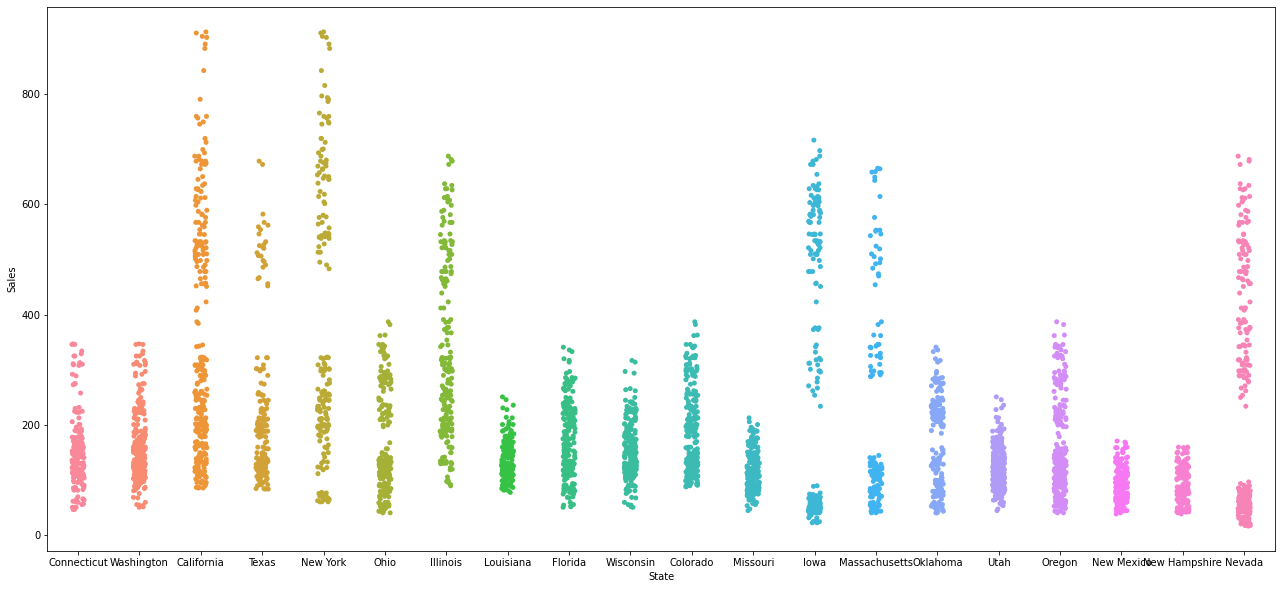

In [14]:
plt.figure(figsize=(22,10))
sns.stripplot(x='State',y='Sales',data=df)

Теперь посмотрим кумулятивные продажи по топ 10 штатов

In [15]:
fig=px.bar(df.groupby('State',as_index=False)['Sales'].mean().sort_values(by='Sales',ascending=False).head(10),
           x='State',y='Sales',color='State',labels={'State':'State','Sales':'Sales in $'},
           template='ggplot2',text='Sales',title='<b> Топ 10 штатов с наибольшими продажами')
fig.show()

Теперь посмотрим, как распределяются продажи по типам продуктов в этих штатах

In [16]:
# Найдем топ 10 штатов по продажам
top_10 = df.groupby('State',as_index=False)['Sales'].mean().sort_values(by='Sales',ascending=False).head(10)['State'].values

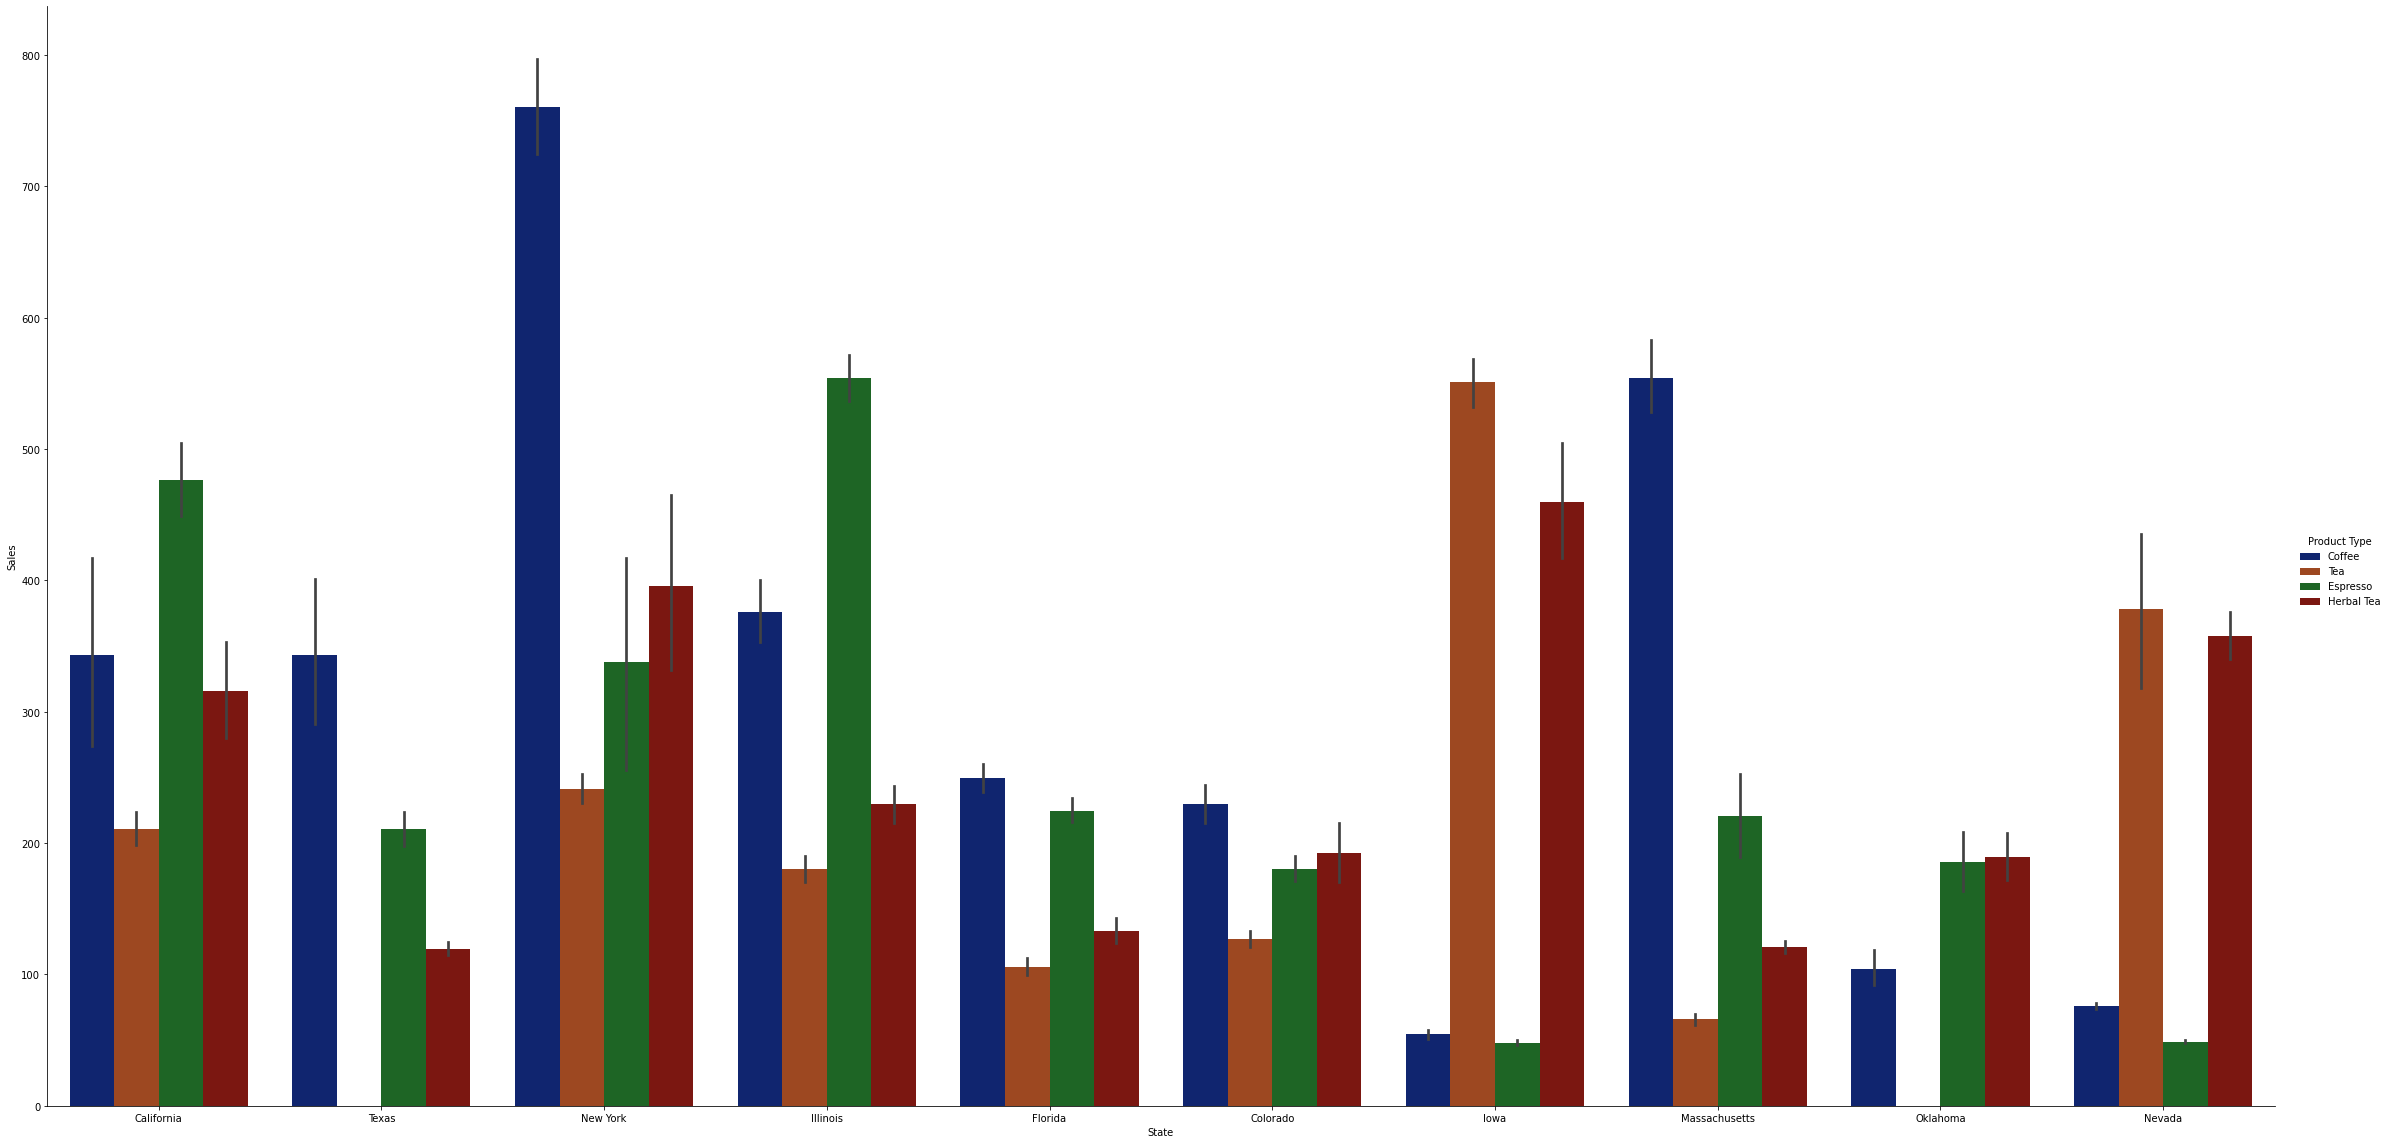

In [17]:
sns.catplot(
    data=df.loc[df['State'].isin(top_10)], kind="bar",
    x="State", y="Sales", hue="Product Type",
    palette="dark", height=16, aspect=2,
)

Посмотрим динамику продаж по типам продуктов по месяцам

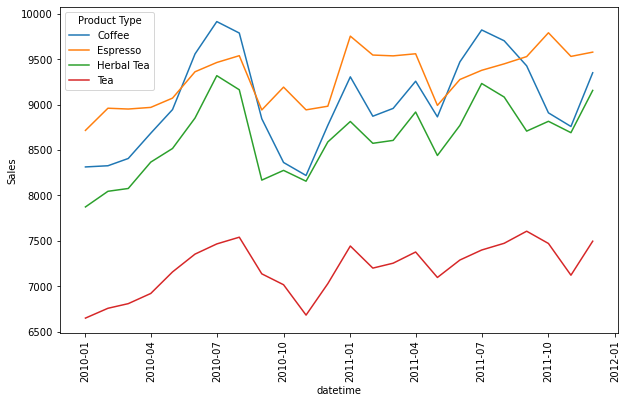

In [18]:
# конвертируем строку в дату
df['datetime'] = pd.to_datetime(df['Date'])
sells = df.groupby(['datetime','Product Type'],as_index=False)['Sales'].sum()

plt.figure(figsize=(10,6))
sns.lineplot(x='datetime',y='Sales', data=sells,hue='Product Type')
plt.xticks(rotation=90);

[Text(0.5, 1.0, 'Total Expenses vs Marketing')]

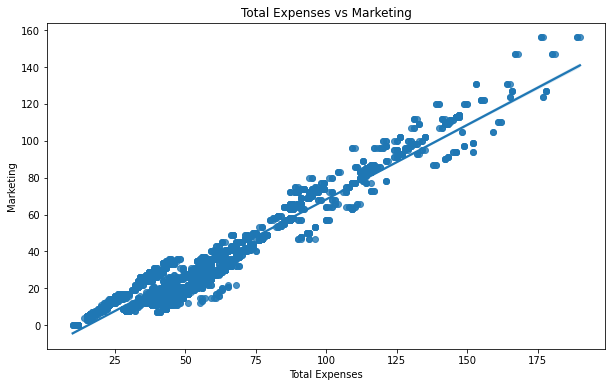

In [19]:
plt.figure(figsize=(10,6))
sns.regplot(x='Total Expenses', y='Marketing', data=df).set(title='Total Expenses vs Marketing')

Зависимость трат от маркетинга линейная, это значит, что основные затраты уходят на маркетинг

**Корреляция**

Text(0.5, 1.0, 'Корреляция численных признаков')

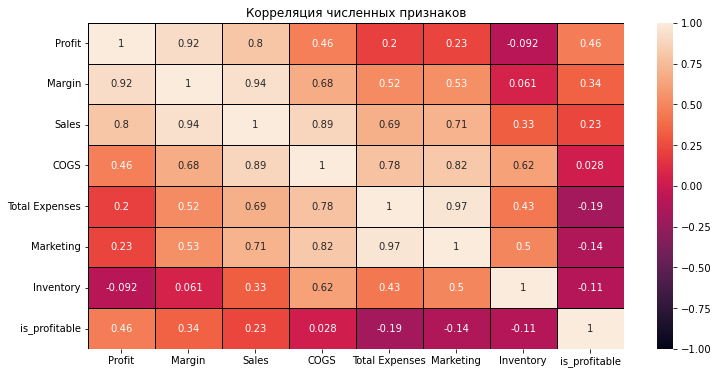

In [20]:
corr_df = df.drop(['Area Code','ProductId','Budget Profit','Budget COGS','Budget Margin','Budget Sales'],axis=1).corr()
plt.figure(figsize=(12,6))
heatmap=sns.heatmap(corr_df,annot=True,vmin=-1,vmax=1,linewidths=1,linecolor='Black')
heatmap.set_title('Корреляция численных признаков')

Margin коррелирует с Profit, Sales с Margin.

Построим график зависимости каждого признака с каждым

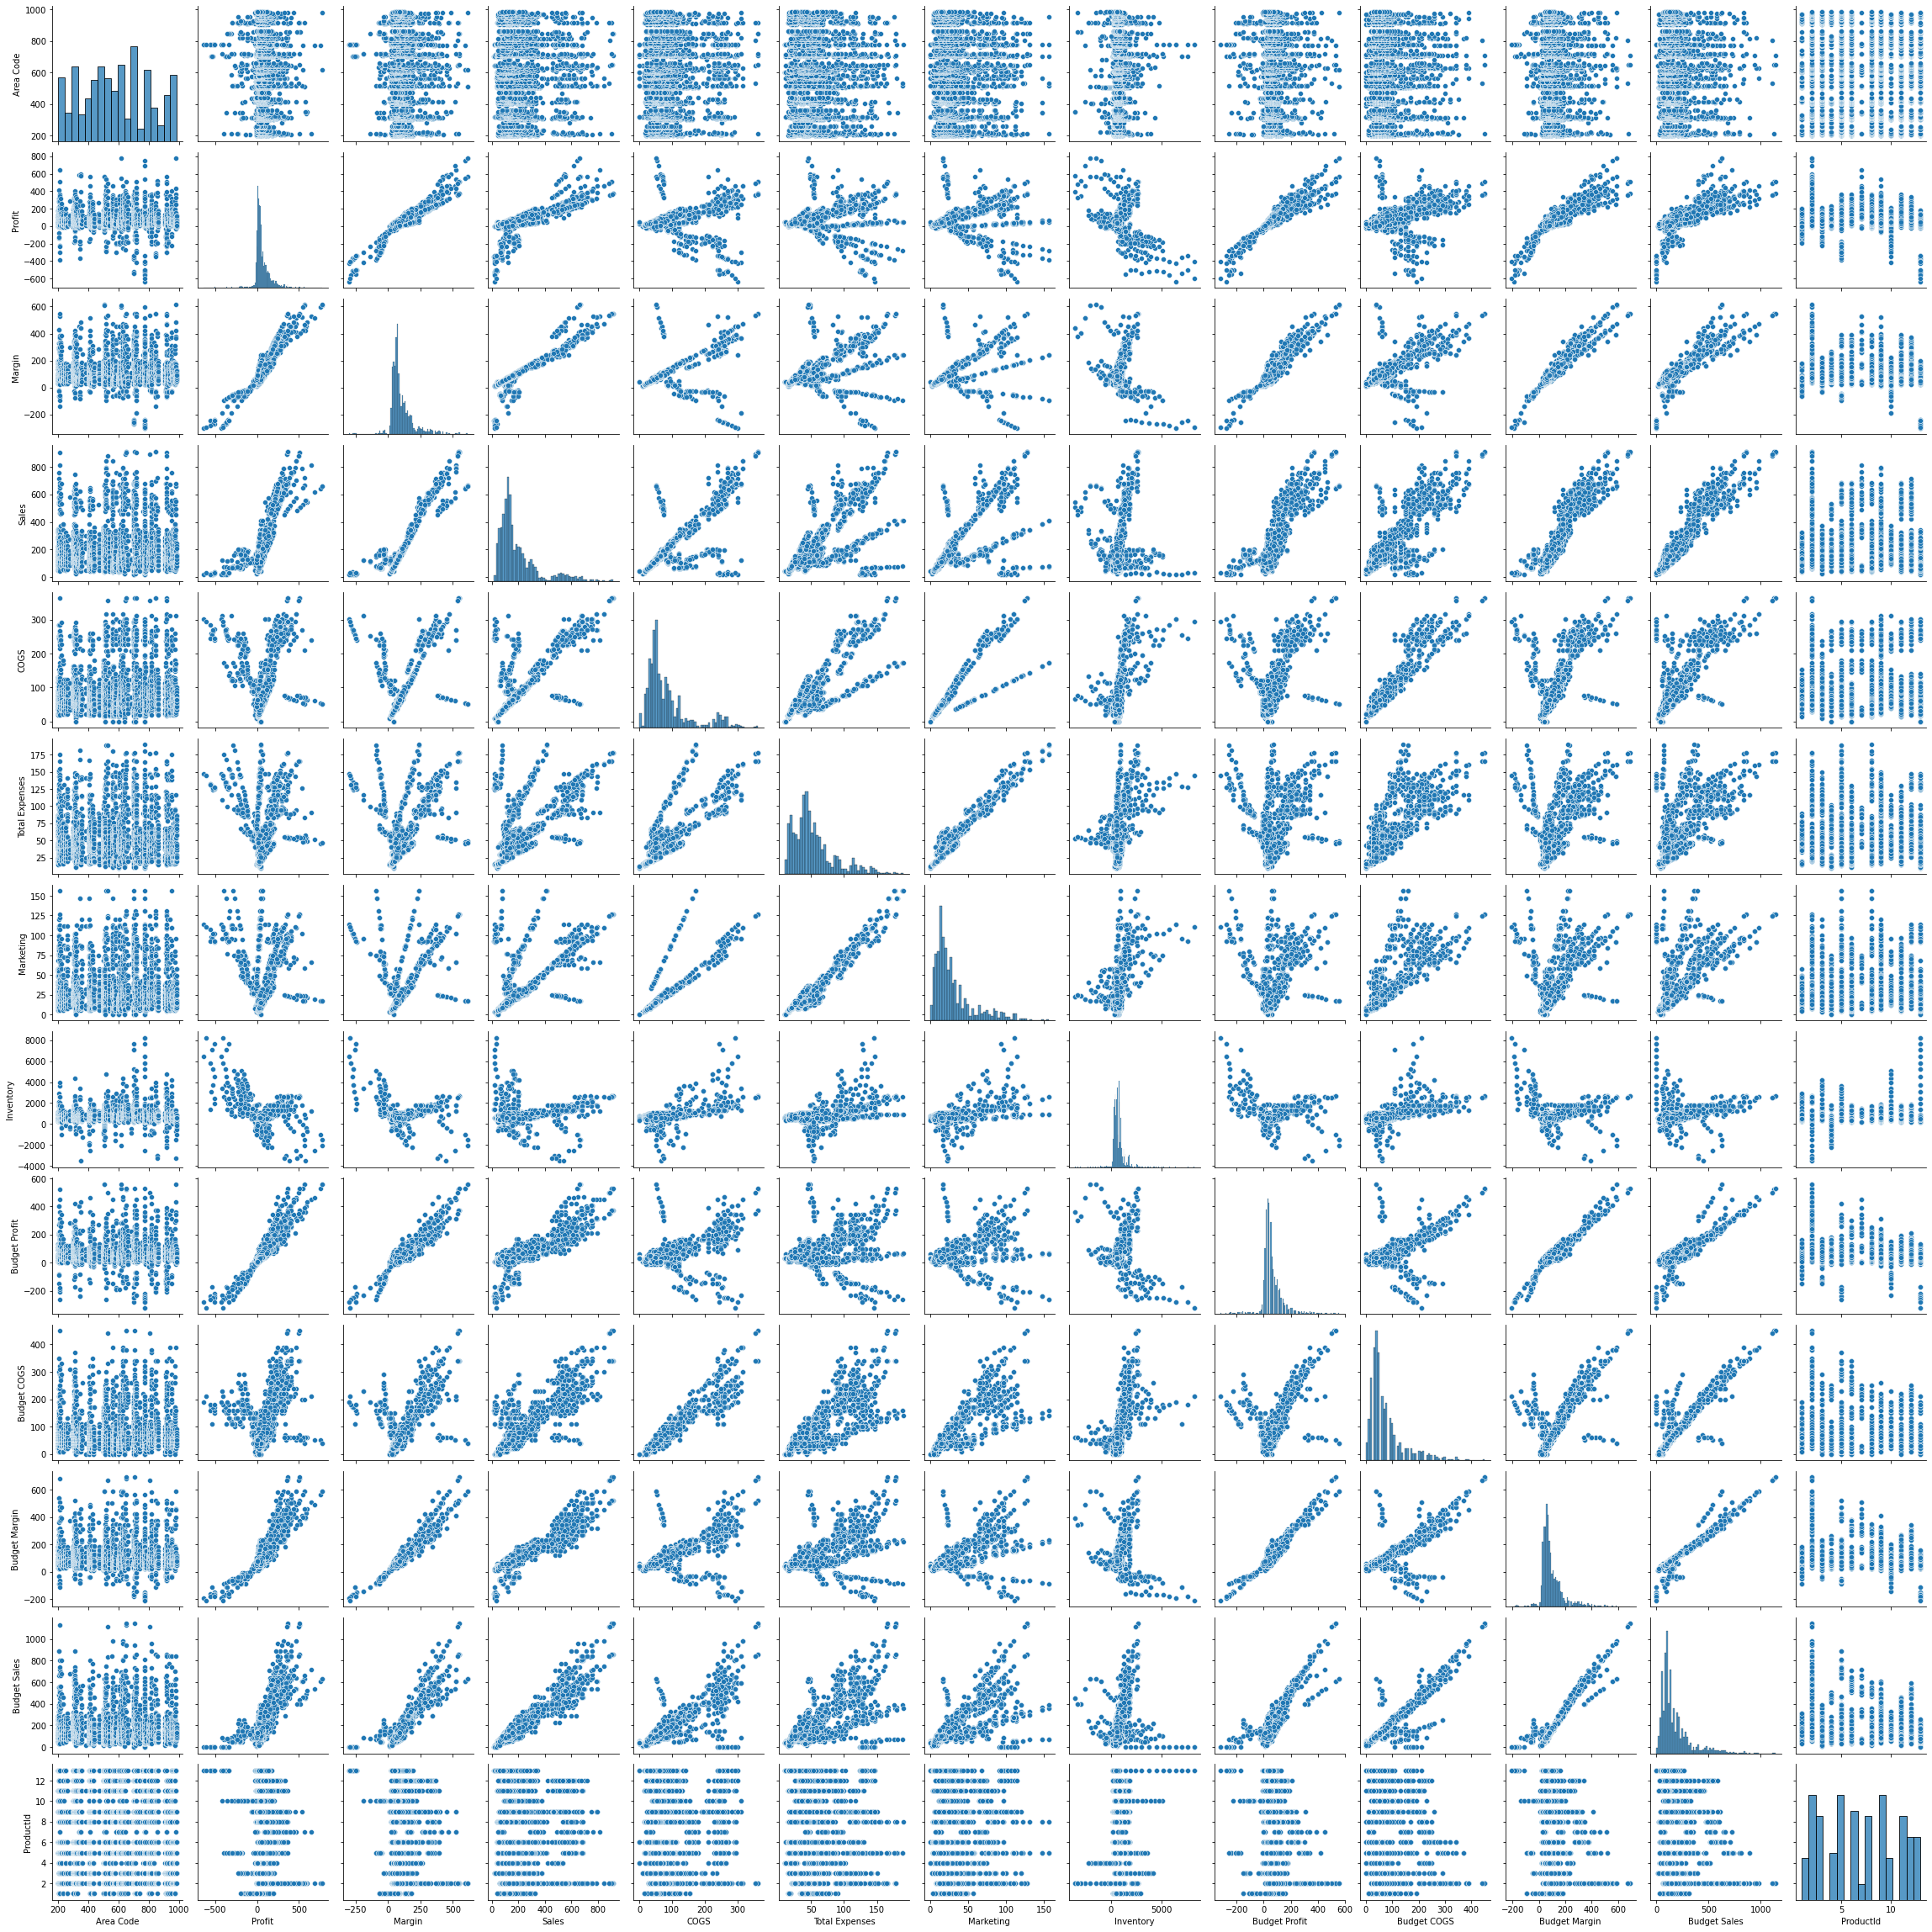

In [21]:
sns.pairplot(df.drop(columns=['is_profitable']))

<AxesSubplot:xlabel='Profit'>

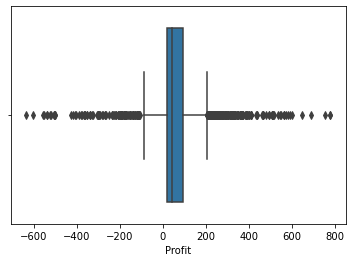

In [22]:
# посмотрим на box plot прибыли и маркетинга, чтобы найти выбросы
sns.boxplot(data=df, x='Profit')

Замечаем огромное количество выбросов. Посмотрим, похоже ли на нормальное распределение 

<AxesSubplot:>

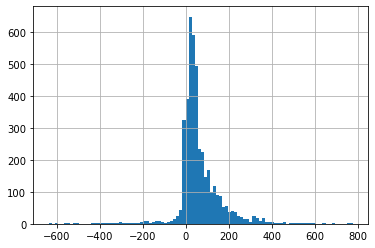

In [23]:
df['Profit'].hist(bins=100)

Распределение не похоже на нормальное, проверим это с помощью теста Шапиро-Уилка

In [24]:
shapiro(df['Profit'])[1]

0.0

Получаем p-value равное нулю, значит, отвергаем гипотезу о нормальности распределения

Проверим следующую гипотезу – H_0 средняя прибыль на восточном и западном рынках США одинакова против против H_1 – средняя прибыль различается. Проверим с помощью t-test

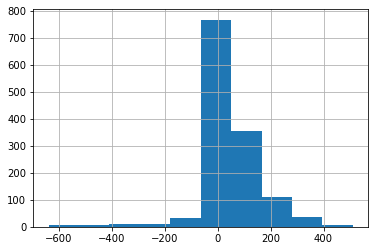

In [47]:
# посмотрим на их распределения и сравним "на глаз"

df.loc[df['Market'] == 'West']['Profit'].hist();

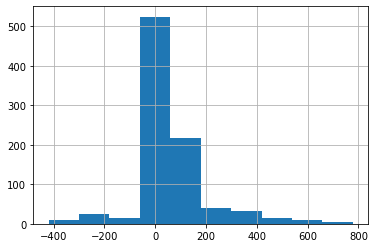

In [26]:
df.loc[df['Market'] == 'East']['Profit'].hist();

Посмотрим на их выборочные дисперсии

In [27]:
df.loc[df['Market'] == 'East']['Profit'].var(), df.loc[df['Market'] == 'West']['Profit'].var()

(19105.823383558305, 12969.21943587562)

Т.к. дисперсии не равны, будем использовать версию теста для выборок с разными дисперсиями

In [28]:
# кажется, что средние одинаковые, не считая выбросов. Проверим

_, p = ttest_ind(df.loc[df['Market'] == 'East']['Profit'], df.loc[df['Market'] == 'West']['Profit'], equal_var=False)
p

0.037393560538588916

На стандартном уровне значимости 0.05 отвергаем эту гипотезу в пользу альтернативы, таким образом, можем считать, что средняя выручка у магазинов на востоке и западе отличается. Проведем односторонний тест, чтобы уточнить, где среднее больше

In [29]:
_, p = ttest_ind(df.loc[df['Market'] == 'East']['Profit'], df.loc[df['Market'] == 'West']['Profit'], equal_var=False, alternative='less')
p

0.9813032197307056

Получили p-value равное почти 1, что означает высокую уверенность в гипотезе: средняя прибыль на востоке больше

Проверим гипотезу H_0 – убыточность магазина не коррелирует с его положением против альтернативы, что корреляция есть Для этого используем chi-square тест

In [30]:
table = [[], []]
total = len(df['is_profitable'])
for i in df['Market'].unique():
  s = df[df['Market'] == i]['is_profitable'].sum()
  table[0].append(s)
  table[1].append(total - s)

In [31]:
chi2_contingency(table)[1]

7.178864652745468e-79

p-value фактически ноль, что говорит об уверенности теста в присутствии корреляции

**Линейная регрессия**\
Попробуем при помощи линейной регрессии предсказывать продажи магазина

In [32]:
linreg = LinearRegression()

In [33]:
df.head()

Area Code        State Market   Market Size  Profit  Margin  Sales   COGS  \
0        203  Connecticut   East  Small Market   107.0   176.0  292.0  116.0   
1        203  Connecticut   East  Small Market    75.0   135.0  225.0   90.0   
2        203  Connecticut   East  Small Market   122.0   195.0  325.0  130.0   
3        203  Connecticut   East  Small Market   105.0   174.0  289.0  115.0   
4        203  Connecticut   East  Small Market   104.0   135.0  223.0   90.0   

   Total Expenses  Marketing  ...  Budget COGS  Budget Margin  Budget Sales  \
0            69.0       38.0  ...        110.0          160.0         270.0   
1            60.0       29.0  ...         80.0          130.0         210.0   
2            73.0       42.0  ...        110.0          180.0         290.0   
3            69.0       37.0  ...        100.0          160.0         260.0   
4            56.0       29.0  ...         80.0          130.0         210.0   

   ProductId               Date  Product Type    Product     Type  \
0          2  04/01/10 00:00:00        Coffee  Columbian  Regular   
1          2  07/01/10 00:00:00        Coffee  Columbian  Regular   
2          2  11/01/10 00:00:00        Coffee  Columbian  Regular   
3          2  12/01/10 00:00:00        Coffee  Columbian  Regular   
4          2  07/01/11 00:00:00        Coffee  Columbian  Regular   

  is_profitable   datetime  
0          True 2010-04-01  
1          True 2010-07-01  
2          True 2010-11-01  
3          True 2010-12-01  
4          True 2011-07-01  

[5 rows x 22 columns]

Text(0.5, 1.0, 'Корреляция численных признаков')

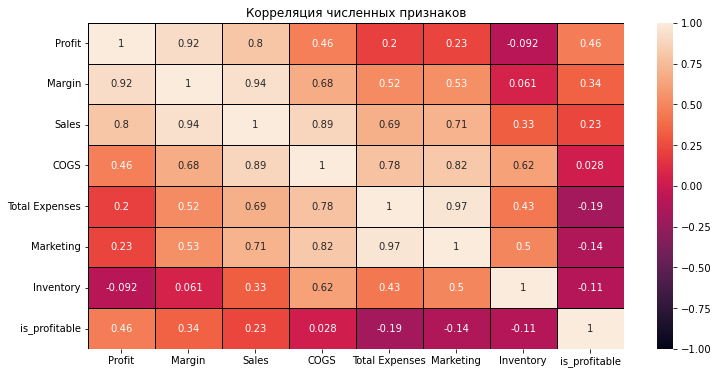

In [34]:
# Посмотрим еще раз на таблицу корреляции
corr_df = df.drop(['Area Code','ProductId','Budget Profit','Budget COGS','Budget Margin','Budget Sales'],axis=1).corr()
plt.figure(figsize=(12,6))
heatmap=sns.heatmap(corr_df,annot=True,vmin=-1,vmax=1,linewidths=1,linecolor='Black')
heatmap.set_title('Корреляция численных признаков')

Видим, что Margin и Sales, COGS и Sales имеют высокий коэффициент корреляции, поэтому отбросим некоторые из этих признаков, чтобы не было мультиколлинеарности. Также отбросим признаки State, Budget *, Product Type, Product, Type, Date

In [35]:
df_linreg = df.drop(
    columns=[
        'datetime',
        'Margin',
        'COGS', 
        'is_profitable', 
        'Date', 
        'ProductId', 
        'Budget Profit', 
        'Budget COGS',
        'Budget Margin',
        'Budget Sales',
        'Product Type',
        'Product',
        'Type',
        'State',
        ]
    )

In [36]:
df_linreg.head()

Area Code Market   Market Size  Profit  Sales  Total Expenses  Marketing  \
0        203   East  Small Market   107.0  292.0            69.0       38.0   
1        203   East  Small Market    75.0  225.0            60.0       29.0   
2        203   East  Small Market   122.0  325.0            73.0       42.0   
3        203   East  Small Market   105.0  289.0            69.0       37.0   
4        203   East  Small Market   104.0  223.0            56.0       29.0   

   Inventory  
0      962.0  
1     1148.0  
2     1134.0  
3     1166.0  
4     1148.0

In [37]:
# сделаем label encoding для категориальных переменных
df_linreg['Market_c'] = df_linreg['Market'].astype('category').cat.codes 
df_linreg['Market Size_c'] = df_linreg['Market Size'].astype('category').cat.codes 

In [38]:
df_linreg.drop(columns=['Market', 'Market Size'], inplace=True)

In [39]:
df_linreg.head()

Area Code  Profit  Sales  Total Expenses  Marketing  Inventory  Market_c  \
0        203   107.0  292.0            69.0       38.0      962.0         1   
1        203    75.0  225.0            60.0       29.0     1148.0         1   
2        203   122.0  325.0            73.0       42.0     1134.0         1   
3        203   105.0  289.0            69.0       37.0     1166.0         1   
4        203   104.0  223.0            56.0       29.0     1148.0         1   

   Market Size_c  
0              1  
1              1  
2              1  
3              1  
4              1

In [40]:
#  проверим модель с помощью кросс-валидации

X = df_linreg.drop(columns=['Sales'])
y = df_linreg['Sales']
-cross_val_score(linreg, X, y, scoring='neg_mean_squared_error').mean()

981.4334833867804

In [41]:
# Проверим, какая ошибка была бы у простого предсказания – среднего значения

df_linreg['mean'] = df_linreg['Sales'].mean()
mean_squared_error(y, df_linreg['mean'])

22835.84518332101

Результат получился намного лучше, значит, модель действительно дала выигрыш. Теперь попробуем одну из самых популярных моделей – градиентный бустинг, а именно CatBoost

In [42]:
cbr = CatBoostRegressor(silent=True)

In [43]:
-cross_val_score(cbr, X, y, scoring='neg_mean_squared_error').mean()

138.284314774422

Даже не перебирая гиперпараметры, получили гораздо лучший результат.

**Логистическая регрессия**\
Попробуем теперь предсказать объем рынка магазина (Market Size)

In [44]:
logreg = LogisticRegression(max_iter=1000)
y_cl = df_linreg['Market Size_c']
X_cl = df_linreg.drop(columns=['Market Size_c'])

In [45]:
cross_val_score(logreg, X_cl, y_cl, scoring='roc_auc').mean()

0.78294120782604

Получили 0.78 roc auc, что довольно неплохо. Теперь попробуем градиентный спуск

In [46]:
cross_val_score(CatBoostClassifier(silent=True), X_cl, y_cl, scoring='roc_auc').mean()

0.74744835820466

На удивление, градиентный спуск даже отработал хуже

**Выводы по проделанной работе**
1. Наибольшие продажи в Америке у кофе, самая популярная марка Columbian
2. Самый большой объем продаж в New York, кофе там самое покупаемый продукт
3. Пик продаж кофе был в июле
4. Анализ затрат показал, что основные затраты приходятся на маркетинг
5. Margin коррелирует с Profit, Sales с Margin
6. Общая прибыль не имеет нормальное распределение
7. Средняя прибыль на востоке больше, чем на западе
8. Убыточность коррелируетс с положением магазина
9. С помощью линейной регресси получилось предсказать продажи магазина. Градиентный бустинг предсказывает это намного лучше
10. С помощью линейной регрессии удалось предсказать объем рынка магазина, но в этой задаче градиентный бустинг показал результаты хуже